In [1]:
# Import necessary modules
import math
import datetime
import numpy as np
import pandas as pd
from fpdf import FPDF
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle, islice

In [2]:
# Set the Country to be pulled
country = 'china' # 'chinese' for China and 'korean' for Korea
# Set user name
UN = 'mfitz' # 'mfitz' for LAPPIE, 'Me' for GLaDOS
# Define the path where the DBs are stored
path = r'C:\Users\{}\Documents\GitHub Clones\{}-students'.format(UN, country)

In [3]:
# Set the path of the Database files
oPath = 'database/tables'
# Read all the sheets from the excel file.
students = pd.read_csv('{}/students.csv'.format(oPath), header = 0)
classes = pd.read_csv('{}/classes.csv'.format(oPath), header = 0)
tests = pd.read_csv('{}/tests.csv'.format(oPath), header = 0)
test_results = pd.read_csv('{}/test_results.csv'.format(oPath), header = 0)
attendance = pd.read_csv('{}/attendance.csv'.format(oPath), header = 0)
hw = pd.read_csv('{}/hw_assignments.csv'.format(oPath), header = 0)
hw_results = pd.read_csv('{}/hw_grades.csv'.format(oPath), header = 0)
participation = pd.read_csv('{}/participation.csv'.format(oPath), header = 0)
points = pd.read_csv('{}/points.csv'.format(oPath), header = 0)
# Merge attendance and class ID from students
attendance = pd.merge(attendance, students[['STUDENT_ID', 'CLASS_ID']], how = 'inner', on = 'STUDENT_ID')
# Get a list of ALL Class IDs
lClasses = classes['CLASS_ID'].to_list()
# Get a list of ALL Student IDs
lStudents = students['STUDENT_ID'].to_list()

In [66]:
# FUNCTIONS

# Define a function to show values at scatter plot points
def fShowValuesScatter(axis, x, y, decimals, ychange):
    for i, j in zip(x, y):
        axis.annotate('{:.{}f}'.format(j, decimals), 
                        xy = (i, j), 
                        xytext=(ychange, 0), 
                        textcoords="offset points", 
                        va='center')
        
# Define a function to show values on bar plots
def fShowValuesOnBars(axs, decimals):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + 0.05
            value = '{:.{}f}'.format(p.get_height(), decimals)
            ax.text(_x, _y, value, ha="center") 
    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

# Define a function to show values on bar plots
def fShowValuesOnBarsCenter(axs, decimals, yMod):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() / yMod
            value = '{:.{}f}'.format(p.get_height(), decimals)
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

# Add standard deviations to a DataFrame
def fStandardDeviation(dataframe, column):
    mean = dataframe[column].mean()
    std = dataframe[column].std()
    dataframe['MEAN_DIFF'] = ''
    dataframe['STD_VAL'] = ''
    for index, i in dataframe.iterrows():
        value = dataframe[column][index]
        meanDiff = value - mean
        if meanDiff < 0:
            neg = '-'
        else:
            neg = ''
        if meanDiff <= std:
            stdVal = neg + str(1)
        elif meanDiff <= std*2:
            stdVal = neg + str(2)
        elif meanDiff <= std*3:
            stdVal = neg + str(3)
        elif meanDiff <= std*4:
            stdVal = neg + str(4)
        else:
            pass
        dataframe['MEAN_DIFF'][index] = meanDiff
        dataframe['STD_VAL'][index] = stdVal
    dataframe = dataframe.astype({'MEAN_DIFF':'float32', 'STD_VAL':'int32'})

In [5]:
# Set the class ID
tiClassID = 1
# Get a list of Student IDs in this class
lStudentsInCurrentClass = students['STUDENT_ID'].where(students['CLASS_ID'] == tiClassID)
lStudentsInCurrentClass.dropna(how = 'all', inplace = True)
lStudentsInCurrentClass = lStudentsInCurrentClass.astype({'STUDENT_ID': 'int32'})
lStudentsInCurrentClass = lStudentsInCurrentClass.reset_index(drop = True)

# Monthly Report

In [6]:
# Set the month and year
tiYear = 2014
tiMonth = 10
# Get the month name from its number
oMonth = datetime.date(tiYear, tiMonth, 1).strftime('%B')
# Get previous month name
oMonthLast = datetime.date(tiYear, tiMonth - 1, 1).strftime('%B')
# Get the number of students in this class
oNumberStudents = students[students['CLASS_ID'] == tiClassID].shape[0]

## For the User-defined Class

### PREPARE DATAFRAMES

In [7]:
# Students DF
dfStudents = students.where(students['CLASS_ID'] == tiClassID)
dfStudents.dropna(how = 'all', inplace = True)
dfStudents = dfStudents.astype({'STUDENT_ID': 'int32', 'STUDENT_AGE': 'int32', 'CLASS_ID': 'int32'})
dfStudents = dfStudents.reset_index(drop = True)
# Test Scores DF
dfTestScores = test_results.where(test_results['CLASS_ID'] == tiClassID)
dfTestScores.dropna(how = 'all', inplace = True)
dfTestScores = dfTestScores.astype({'STUDENT_ID': 'int32', 'TEST_ID': 'int32', 'TEST_SCORE': 'int32', 'TEST_SCORE_MAX': 'int32', 'CLASS_ID': 'int32'})
dfTestScores['TEST_DATE'] = pd.to_datetime(dfTestScores['TEST_DATE'])
dfTestScores = dfTestScores.reset_index(drop = True)
# Get a list of all Test IDs
lTestIDs = dfTestScores['TEST_ID'].unique()
# Attendance DF
dfAttendance = attendance.where(attendance['CLASS_ID'] == tiClassID)
dfAttendance.dropna(how = 'all', inplace = True)
dfAttendance = dfAttendance.astype({'STUDENT_ID': 'int32', 'CLASS_ID': 'int32'})
dfAttendance['CLASS_DATE'] = pd.to_datetime(dfAttendance['CLASS_DATE'])
dfAttendance = dfAttendance.reset_index(drop = True)
# HW Scores DF
dfHWScores = hw_results.where(hw_results['CLASS_ID'] == tiClassID)
dfHWScores.dropna(how = 'all', inplace = True)
dfHWScores = dfHWScores.astype({'STUDENT_ID': 'int32', 'HW_ID': 'int32', 'HW_SCORE': 'int32', 'HW_SCORE_MAX': 'int32', 'CLASS_ID': 'int32'})
dfHWScores['HW_ASSIGNED_DATE'] = pd.to_datetime(dfHWScores['HW_ASSIGNED_DATE'])
dfHWScores['HW_TURNED_IN_DATE'] = pd.to_datetime(dfHWScores['HW_TURNED_IN_DATE'])
dfHWScores = dfHWScores.reset_index(drop = True)
# Get a list of all the HW IDs
lHWIDs = dfHWScores['HW_ID'].unique() 
# Participation DF
dfParticipation = participation.where(participation['CLASS_ID'] == tiClassID)
dfParticipation.dropna(how = 'all', inplace = True)
dfParticipation = dfParticipation.astype({'STUDENT_ID': 'int32', 'PARTICIPATION_ATTEMPTS': 'int32', 'PARTICIPATION_HINTS': 'int32', 'CLASS_ID': 'int32'})
dfParticipation['PARTICIPATION_DATETIME'] = pd.to_datetime(dfParticipation['PARTICIPATION_DATETIME'])
dfParticipation = dfParticipation.reset_index(drop = True)
# Tests DF
dfTests = tests[tests['TEST_ID'].isin(lTestIDs)]
dfTests.dropna(how = 'all', inplace = True)
dfTests['TEST_DATE'] = pd.to_datetime(dfTests['TEST_DATE'])
dfTests = dfTests.reset_index(drop = True)
# HW DF
dfHW = hw[hw['HW_ID'].isin(lHWIDs)]
dfHW.dropna(how = 'all', inplace = True)
dfHW['HW_ASSIGNED_DATE'] = pd.to_datetime(dfHW['HW_ASSIGNED_DATE'])
dfHW['HW_DUE_DATE'] = pd.to_datetime(dfHW['HW_DUE_DATE'])
dfHW = dfHW.reset_index(drop = True)
# POINTS DF
dfPoints = pd.merge(points, students[['STUDENT_ID', 'CLASS_ID', 'STUDENT_NAME_ENGLISH']], on = 'STUDENT_ID')
dfPoints = dfPoints.where(dfPoints['CLASS_ID'] == tiClassID)
dfPoints.dropna(how = 'all', inplace = True)
dfPoints = dfPoints.astype({'STUDENT_ID':'int32', 'CLASS_ID':'int32', 'PARTICIPATION_POINTS':'int32', 'HW_POINTS':'int32', 'TEST_POINTS':'int32', 'ATTENDANCE_POINTS':'int32', 'TOTAL_POINTS':'int32'})
dfPoints = dfPoints.reset_index(drop = True)

# TESTS
# Test Scores
dfTestScoresDate = dfTestScores.where((dfTestScores['TEST_DATE'].dt.year == tiYear) & (dfTestScores['TEST_DATE'].dt.month == tiMonth))
dfTestScoresDateMinus1 = dfTestScores.where((dfTestScores['TEST_DATE'].dt.year == tiYear) & (dfTestScores['TEST_DATE'].dt.month == tiMonth - 1))
dfTestScoresDateMinus2 = dfTestScores.where((dfTestScores['TEST_DATE'].dt.year == tiYear) & (dfTestScores['TEST_DATE'].dt.month == tiMonth - 2))
# Test Names
dfTestsDate = dfTests.where((dfTests['TEST_DATE'].dt.year == tiYear) & (dfTests['TEST_DATE'].dt.month == tiMonth))
# ATTENDANCE
dfAttendanceDate = dfAttendance.where((dfAttendance['CLASS_DATE'].dt.year == tiYear) & (dfAttendance['CLASS_DATE'].dt.month == tiMonth))
dfAttendanceDate.dropna(how = 'all', inplace = True)
# PARTICIPATION
# Current Month
dfParticipationDate = dfParticipation.where((dfParticipation['PARTICIPATION_DATETIME'].dt.year == tiYear) & (dfParticipation['PARTICIPATION_DATETIME'].dt.month == tiMonth))
dfParticipationDate.dropna(how = 'all', inplace = True)
dfParticipationDate = dfParticipationDate.reset_index(drop = True)
# Current Month - 1
dfParticipationDateMinus1 = dfParticipation.where((dfParticipation['PARTICIPATION_DATETIME'].dt.year == tiYear) & (dfParticipation['PARTICIPATION_DATETIME'].dt.month == tiMonth - 1))
dfParticipationDateMinus1.dropna(how = 'all', inplace = True)
dfParticipationDateMinus1 = dfParticipationDateMinus1.reset_index(drop = True)
# HOMEWORK
# Homework Assignments
dfHWDate = dfHW.where((dfHW['HW_ASSIGNED_DATE'].dt.year == tiYear) & (dfHW['HW_ASSIGNED_DATE'].dt.month == tiMonth))
# Homework Scores
dfHWScoresDate = dfHWScores.where((dfHWScores['HW_ASSIGNED_DATE'].dt.year == tiYear) & (dfHWScores['HW_ASSIGNED_DATE'].dt.month == tiMonth))

# Can use this to loopify the above?
lDFs = [dfStudents, dfTestScores, dfAttendance, dfHWScores, dfParticipation, dfTests, dfHW]

In [8]:
dfAttendanceAbsent = attendance.where(attendance['ATTENDANCE_STATUS'] == 'absent')
dfAttendanceAbsent.dropna(how = 'all', inplace = True)

### Test Grades

#### *Prepare the DataFrames*

In [9]:
# Merge the test results DF with students DF for the specified class
dfTestScoresDate = pd.merge(dfTestScoresDate, dfStudents, on = 'STUDENT_ID')
# Sort the DF by test score in descending order
dfTestScoresDate = dfTestScoresDate.sort_values(by = 'TEST_SCORE', ascending = False)
# Calculate the average score for each student
oTestScoreMean = dfTestScoresDate['TEST_SCORE'].mean()

#### *Plots*

In [69]:
# Current Month's Test Scores
# Set the title
oTitle = f"({tiMonth}-{tiYear}) Class {tiClassID} - Test Scores"
# Plot the data
ax = dfTestScoresDate.plot.bar(x = 'STUDENT_NAME_ENGLISH', y = 'TEST_SCORE', figsize=(20,8), label='Test Score')
# Plot the this month's HW average score
plt.axhline(y = oTestScoreMean, color = 'darkblue', linestyle = 'dashed', label = '{} Test Average'.format(oMonth))
# Set up the legend
plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0)
# Format the graph
tSubtitle = 'Class {} - {}, {}'.format(tiClassID, oMonth, tiYear)
plt.suptitle("Test Scores", size = 28, fontweight = "bold", y = 0.96, ha = 'center')
ax.set_title(tSubtitle, size = 14, ha = 'center')
ax.set_xlabel("Name", size = 18, style="italic")
ax.set_ylabel("Test Score", size = 18, style="italic")
# Add labels
fShowValuesOnBars(ax, 0)
# Save the figure as png
ax.figure.savefig(f"Images\{oTitle}.png", bbox_inches = 'tight')
# Append the plot to a list
lParticipationPlots.append(f"{oTitle}.png")
# Close the plot to stop it dislaying
plt.close()

### Homework Grades

#### *Prepare the DataFrames*

In [11]:
# Merge the HW grades with students DF for the specified class
dfHWScoresDate = pd.merge(dfHWScoresDate, dfStudents[['STUDENT_ID', 'STUDENT_NAME_ENGLISH']], on = 'STUDENT_ID')
dfHWScoresDate.dropna(how = 'all', inplace = True)
# Calculate the average score for each student
dfHWScoresDateAverages = dfHWScoresDate.groupby(['STUDENT_NAME_ENGLISH'])['HW_SCORE'].mean()
# Turn the above series into a DataFrame
dfHWScoresDateAverages = pd.DataFrame(dfHWScoresDateAverages)

#### *Plots*

In [68]:
# Set the title
oTitle = f"({tiMonth}-{tiYear}) Class {tiClassID} - HW Scores (Scatter)"
# Plot the data
ax = dfHWScoresDate.plot.scatter(x = 'STUDENT_NAME_ENGLISH', y = 'HW_SCORE', c = 'HW_ID', s = 150, figsize=(25, 8))
# Plot the average for each HW_ID
lColors = ['darkblue', 'orange', 'darkgreen', 'lightgreen', 'blue', 'purple', 'red']
oColor = 0
for i in list(dfHWScoresDate['HW_ID'].unique()):
    plt.axhline(y = dfHWScoresDate['HW_SCORE'].where(dfHWScoresDate['HW_ID'] == int(i)).mean(), 
            color = lColors[oColor], linestyle = 'dashed', label = f'HW {int(i)} Average')
    oColor += 1
# Set up the legend
plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0)
# Format the graph
tSubtitle = 'Class {} - {}, {}'.format(tiClassID, oMonth, tiYear)
plt.suptitle("HW Scores", size = 28, fontweight = "bold", y = 0.96, ha = 'center')
ax.set_title(tSubtitle, size = 14, ha = 'center')
ax.set_xlabel("Name", size = 18, style="italic")
ax.set_ylabel("HW Score", size = 18, style="italic")
ax.set(ylim = (-1, 10))
# Add labels
x = dfHWScoresDate['STUDENT_NAME_ENGLISH']
y = dfHWScoresDate['HW_SCORE']
fShowValuesScatter(ax, x, y, 0, 7)
# Save the figure as png
ax.figure.savefig(f"Images\{oTitle}.png", bbox_inches = 'tight')
# Append the plot to a list
lParticipationPlots.append(f"{oTitle}.png")
# Close the plot to stop it dislaying
plt.close()

#### Using Subplots

In [67]:
# Set the title
oTitle = f"({tiMonth}-{tiYear}) Class {tiClassID} - HW Scores"
# Get the number of IDs
blah = dfHWScoresDate.sort_values(by = 'HW_ID')
oIDCount = len(list(blah['HW_ID'].unique()))
# Define the figure and axis
fig, axes = plt.subplots(oIDCount)
# Define the colors list
lColors = ['darkblue', 'orange', 'darkgreen', 'lightgreen', 'blue', 'purple', 'red']
# Define the color index
oColor = 0
# Loop through the HW_IDs
for i in list(dfHWScoresDate['HW_ID'].unique()):
    # Pull the scores for the specific HW_ID
    df = dfHWScoresDate.where(dfHWScoresDate['HW_ID'] == int(i))
    # Turn it into a DF to make it easily to manipulate
    df = pd.DataFrame(df)
    # Drop NANs
    df.dropna(how = 'all', inplace = True)
    # Plot the subplot
    df.plot.bar(x = 'STUDENT_NAME_ENGLISH', y = 'HW_SCORE', 
                ax = axes[oColor], figsize=(30,12), 
                label = f'HW {int(i)}', color = lColors[oColor],   
                rot = 0)
    # Plot the average for the specific ID
    axes[oColor].axhline(y = dfHWScoresDate['HW_SCORE'].where(dfHWScoresDate['HW_ID'] == int(i)).mean(), 
                            color = lColors[oColor], linestyle = 'dashed', label = f'HW {int(i)} Average')
    # Set up the legend
    axes[oColor].legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0)
    oColor += 1

# Format the graph
tSubtitle = 'Class {} - {}, {}'.format(tiClassID, oMonth, tiYear)
plt.suptitle("HW Scores", size = 28, fontweight = "bold", y = 0.96, ha = 'center')
# Add labels
fShowValuesOnBars(axes, 0)
# Set Labels
for ax in axes.flat:
    ax.set(xlabel='HW Score', ylabel='Student Name')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()
# Save the figure as png
ax.figure.savefig(f"Images\{oTitle}.png", bbox_inches = 'tight')
# Append the plot to a list
lParticipationPlots.append(f"{oTitle}.png")
# Close the plot to stop it dislaying
plt.close()

### Attendance

#### *Prepare the DataFrames*

In [14]:
# Merge the attendance DF with the students DF
dfAttendanceDate = pd.merge(dfAttendanceDate, dfStudents[['STUDENT_ID', 'STUDENT_NAME_ENGLISH']], on = 'STUDENT_ID')
# Group by name and status to get totals for each status by student
dfAttendanceStatus = dfAttendanceDate.groupby(['STUDENT_NAME_ENGLISH', 'ATTENDANCE_STATUS']).count()
# Create new DF of all the instances of an absent status
dfAttendanceDateAbsent = dfAttendanceDate.where(dfAttendanceDate['ATTENDANCE_STATUS'] == 'absent')
# Drop the NANs from this newly created DF
dfAttendanceDateAbsent.dropna(how = 'all', inplace = True)
# Reset the index
dfAttendanceDateAbsent = dfAttendanceDateAbsent.reset_index(drop = True)

#### *Strings/Lists*

In [15]:
oAbsentCount = dfAttendanceDate['ATTENDANCE_STATUS'].str.contains('absent').sum()
# Print the output
if oAbsentCount > 0:
    # Define a list to store all the instances of absent students
    lAbsences = []
    # Loop through the rows to populate the list
    for index, row in dfAttendanceDateAbsent.iterrows():
        # Pull the name from the current row
        oName = dfAttendanceDateAbsent['STUDENT_NAME_ENGLISH'][index]
        # Pull the date from the current row
        oDate = str(dfAttendanceDateAbsent['CLASS_DATE'][index])[0:10]
        # Define a string to be appended to the list
        sText = '{} was absent on {}'.format(oName, oDate)
        # Append the string to the list
        lAbsences.append(sText)   
    print(lAbsences)
else:
    # Define a string to be used in the report
    sMessage = 'No students were absent in {}, {}'.format(oMonth, tiYear)
    print(sMessage)

No students were absent in October, 2014


### Participation

#### *Preparing the DataFrames*

In [16]:
# Merge the student's name with the participation DF
dfParticipationDate = pd.merge(dfParticipationDate, dfStudents[['STUDENT_ID', 'STUDENT_NAME_ENGLISH']], on = 'STUDENT_ID')
dfParticipationDateMinus1 = pd.merge(dfParticipationDateMinus1, dfStudents[['STUDENT_ID', 'STUDENT_NAME_ENGLISH']], on = 'STUDENT_ID')
# Group by participation type and student ID
dfParticipationDateType = dfParticipationDate.groupby(['STUDENT_ID', 'PARTICIPATION_TYPE'])['PARTICIPATION_TYPE'].count()
dfParticipationDateType = pd.DataFrame(dfParticipationDateType)
dfParticipationDateType = dfParticipationDateType.rename(columns = {'STUDENT_ID': 'STUDENT_ID', 'PARTICIPATION_TYPE':'PARTICIPATION_TYPE', 'PARTICIPATION_TYPE':'PART_TYPE_COUNT'})

dfParticipationDateTypeMinus1 = dfParticipationDateMinus1.groupby(['STUDENT_ID', 'PARTICIPATION_TYPE'])['PARTICIPATION_TYPE'].count()
dfParticipationDateTypeMinus1 = pd.DataFrame(dfParticipationDateTypeMinus1)
dfParticipationDateTypeMinus1 = dfParticipationDateTypeMinus1.rename(columns = {'STUDENT_ID': 'STUDENT_ID', 'PARTICIPATION_TYPE':'PARTICIPATION_TYPE', 'PARTICIPATION_TYPE':'PART_TYPE_COUNT'})
# Create a pivot table of the same group by
dfParticipationDateTypePivot = dfParticipationDate.pivot_table(index = 'STUDENT_ID', columns = 'PARTICIPATION_TYPE', values = 'CLASS_ID', aggfunc = 'count')


dfParticipationDateTypePivotMinus1 = dfParticipationDateMinus1.pivot_table(index = 'STUDENT_ID', columns = 'PARTICIPATION_TYPE', values = 'CLASS_ID', aggfunc = 'count')
# Merge it with student names
dfParticipationDateTypePivot = pd.merge(dfParticipationDateTypePivot, dfStudents[['STUDENT_ID', 'STUDENT_NAME_ENGLISH']], on = 'STUDENT_ID')

dfParticipationDateTypePivotMinus1 = pd.merge(dfParticipationDateTypePivotMinus1, dfStudents[['STUDENT_ID', 'STUDENT_NAME_ENGLISH']], on = 'STUDENT_ID')
# Group by student ID and count them to get the total number of participation instances per student
dfParticipationDateCount = dfParticipationDate.groupby(['STUDENT_ID'])['STUDENT_ID'].count()
dfParticipationDateCount = pd.DataFrame(dfParticipationDateCount)
dfParticipationDateCount = dfParticipationDateCount.rename(columns = {'STUDENT_ID': 'STUDENT_ID', 'STUDENT_ID':'PART_COUNT'})

dfParticipationDateCountMinus1 = dfParticipationDateMinus1.groupby(['STUDENT_ID'])['STUDENT_ID'].count()
dfParticipationDateCountMinus1 = pd.DataFrame(dfParticipationDateCountMinus1)
dfParticipationDateCountMinus1 = dfParticipationDateCountMinus1.rename(columns = {'STUDENT_ID': 'STUDENT_ID', 'STUDENT_ID':'PART_COUNT'})
# Merge the part count DF with student names
dfParticipationDateCount = pd.merge(dfParticipationDateCount, dfStudents[['STUDENT_ID', 'STUDENT_NAME_ENGLISH']], on = 'STUDENT_ID')

dfParticipationDateCountMinus1 = pd.merge(dfParticipationDateCountMinus1, dfStudents[['STUDENT_ID', 'STUDENT_NAME_ENGLISH']], on = 'STUDENT_ID')

In [17]:
# Create new DF from students and participation
value_counts = dfParticipationDate['STUDENT_ID'].value_counts()
# Convert value_counts to a DataFrame
dfPart = pd.DataFrame(value_counts)
# Reset its index
dfPart = dfPart.reset_index()
# Rename the columns to make them more readable
dfPart.columns = ['STUDENT_ID', 'PARTICIPATIONS COUNT']
# Merge the dfPart and students DataFrames
dfPart = pd.merge(dfPart, dfStudents[['STUDENT_ID', 'STUDENT_NAME_ENGLISH']], how = 'outer', on = 'STUDENT_ID')

dfByDate = dfParticipationDate.groupby(['STUDENT_ID', 'PARTICIPATION_DATETIME'])['PARTICIPATION_DATETIME'].count()
dfByDateMinus1 = dfParticipationDateMinus1.groupby(['STUDENT_ID', 'PARTICIPATION_DATETIME'])['PARTICIPATION_DATETIME'].count()
dfByDate = pd.DataFrame(dfByDate)
dfByDateMinus1 = pd.DataFrame(dfByDateMinus1)
dfByDate = dfByDate.rename(columns = {'STUDENT_ID': 'STUDENT_ID', 'PARTICIPATION_DATETIME': 'DATETIME', 'PARTICIPATION_DATETIME': 'COUNT'})
dfByDateMinus1 = dfByDateMinus1.rename(columns = {'STUDENT_ID': 'STUDENT_ID', 'PARTICIPATION_DATETIME': 'DATETIME', 'PARTICIPATION_DATETIME': 'COUNT'})

# Define a dictionary to store each student's DF in
dfPC = {}
dfPCMinus1 = {}
# Define a list of Means to store in the new dataframe
lMeanParticipations = []
lMeanParticipationsMinus1 = []
# Loop through the STUDENT_IDs and calculate their mean number of participations
for i in lStudentsInCurrentClass:
    # Copy the DataFrame for safety resons
    dfa = dfByDate
    dfaMinus1 = dfByDateMinus1
    # Create a new DF just for the one student
    dfPC[i] = dfa.loc[i]
    dfPCMinus1[i] = dfaMinus1.loc[i]
    # Set their ID to their ID from the list
    dfPC[i]['STUDENT_ID'] = i
    dfPCMinus1[i]['STUDENT_ID'] = i
    # Calculate the mean participations per class
    dfPC[i]['MEAN'] = dfPC[i]['COUNT'].mean()
    dfPCMinus1[i]['MEAN'] = dfPCMinus1[i]['COUNT'].mean()
    # Sort from highest to lowest count
    dfPC[i] = dfPC[i].sort_values(by = 'COUNT', ascending = False)
    dfPCMinus1[i] = dfPCMinus1[i].sort_values(by = 'COUNT', ascending = False)
    # Append the mean to lMeanParticipations
    lMeanParticipations.append(dfPC[i]['MEAN'][0])
    lMeanParticipationsMinus1.append(dfPCMinus1[i]['MEAN'][0])

# Define an empty list to store the student's mean attempts
lMeanAttempts = []
lMeanAttemptsMinus1 = []
# Define an empty list to store the studnt's mean hints
lMeanHints = []
lMeanHintsMinus1 = []
# Define an empty list to store the student's hint/attempt ratio
lAttemptsHintRatio = []
lAttemptsHintRatioMinus1 = []
# Loop throgh the STUDENT_IDs in the current class and calculate the mean attempts per participation, 
# the mean hints per participation, and the hint/attempts ratio
for i in lStudentsInCurrentClass:
    # Calculate the mean attempts for the specified student 
    oMeanAttempts = dfParticipationDate['PARTICIPATION_ATTEMPTS'].where(dfParticipationDate['STUDENT_ID'] == i).mean()
    oMeanAttemptsMinus1 = dfParticipationDateMinus1['PARTICIPATION_ATTEMPTS'].where(dfParticipationDateMinus1['STUDENT_ID'] == i).mean()
    # Append this mean to the list
    lMeanAttempts.append(oMeanAttempts)
    lMeanAttemptsMinus1.append(oMeanAttemptsMinus1)

    # Calculate the mean hints for the specified student 
    oMeanHints = dfParticipationDate['PARTICIPATION_HINTS'].where(dfParticipationDate['STUDENT_ID'] == i).mean()
    oMeanHintsMinus1 = dfParticipationDateMinus1['PARTICIPATION_HINTS'].where(dfParticipationDateMinus1['STUDENT_ID'] == i).mean()
    # Append this mean to the list
    lMeanHints.append(oMeanHints)
    lMeanHintsMinus1.append(oMeanHintsMinus1)

    # Sum the attempts
    oHintSum = dfParticipationDate['PARTICIPATION_HINTS'].where(dfParticipationDate['STUDENT_ID'] == i).sum()
    oHintSumMinus1 = dfParticipationDateMinus1['PARTICIPATION_HINTS'].where(dfParticipationDateMinus1['STUDENT_ID'] == i).sum()
    # Sum the hints
    oAttemptSum = dfParticipationDate['PARTICIPATION_ATTEMPTS'].where(dfParticipationDate['STUDENT_ID'] == i).sum()
    oAttemptSumMinus1 = dfParticipationDateMinus1['PARTICIPATION_ATTEMPTS'].where(dfParticipationDateMinus1['STUDENT_ID'] == i).sum()
    # Calculate the hint/attempts ratio for the specified student 
    oAttemptHintRatio = oAttemptSum / oHintSum
    oAttemptHintRatioMinus1 = oAttemptSumMinus1 / oHintSumMinus1 
    # Append this ratio to the list
    lAttemptsHintRatio.append(oAttemptHintRatio)
    lAttemptsHintRatioMinus1.append(oAttemptHintRatioMinus1)

# Create a new dataframe of the students and their mean participations per class
dfMeanPart = pd.DataFrame(columns = ['STUDENT_ID', 'MEAN_PARTICIPATIONS_PER_CLASS', 'MEAN_ATTEMPTS_PER_PART_INSTANCE', 'MEAN_HINTS_PER_PART_INSTANCE', 'ATTEMPTS/HINTS_RATIO'])
dfMeanPartMinus1 = pd.DataFrame(columns = ['STUDENT_ID', 'MEAN_PARTICIPATIONS_PER_CLASS', 'MEAN_ATTEMPTS_PER_PART_INSTANCE', 'MEAN_HINTS_PER_PART_INSTANCE', 'ATTEMPTS/HINTS_RATIO'])
# Set the student IDs to lStudents which is a list of student IDs
dfMeanPart['STUDENT_ID'] = lStudentsInCurrentClass
dfMeanPartMinus1['STUDENT_ID'] = lStudentsInCurrentClass
# Populate the MEAN_PARTICIPATIONS_PER_CLASS column
dfMeanPart['MEAN_PARTICIPATIONS_PER_CLASS'] = lMeanParticipations
dfMeanPartMinus1['MEAN_PARTICIPATIONS_PER_CLASS'] = lMeanParticipationsMinus1
# Populate the MEAN_ATTEMPTS_PER_PART_INSTANCE column
dfMeanPart['MEAN_ATTEMPTS_PER_PART_INSTANCE'] = lMeanAttempts
dfMeanPartMinus1['MEAN_ATTEMPTS_PER_PART_INSTANCE'] = lMeanAttemptsMinus1
# Populate the MEAN_HINTS_PER_PART_INSTANCE column
dfMeanPart['MEAN_HINTS_PER_PART_INSTANCE'] = lMeanHints
dfMeanPartMinus1['MEAN_HINTS_PER_PART_INSTANCE'] = lMeanHintsMinus1
# Populate the ATTEMPTS/HINTS_RATIO column
dfMeanPart['ATTEMPTS/HINTS_RATIO'] = lAttemptsHintRatio
dfMeanPartMinus1['ATTEMPTS/HINTS_RATIO'] = lAttemptsHintRatioMinus1
# Merge the new DF with students
dfMeanPart = pd.merge(dfMeanPart, students[['STUDENT_ID', 'STUDENT_NAME_ENGLISH', 'CLASS_ID']], how = 'inner', on = 'STUDENT_ID')
dfMeanPartMinus1 = pd.merge(dfMeanPartMinus1, students[['STUDENT_ID', 'STUDENT_NAME_ENGLISH', 'CLASS_ID']], how = 'inner', on = 'STUDENT_ID')
# Reorder the columns
dfMeanPart = dfMeanPart[['STUDENT_ID', 'STUDENT_NAME_ENGLISH', 'CLASS_ID', 'MEAN_PARTICIPATIONS_PER_CLASS', 'MEAN_ATTEMPTS_PER_PART_INSTANCE', 'MEAN_HINTS_PER_PART_INSTANCE', 'ATTEMPTS/HINTS_RATIO']]
dfMeanPartMinus1 = dfMeanPartMinus1[['STUDENT_ID', 'STUDENT_NAME_ENGLISH', 'CLASS_ID', 'MEAN_PARTICIPATIONS_PER_CLASS', 'MEAN_ATTEMPTS_PER_PART_INSTANCE', 'MEAN_HINTS_PER_PART_INSTANCE', 'ATTEMPTS/HINTS_RATIO']]

In [18]:
# DataFrame of all students and their Cold/Volunteer ratio

# Define an empty DF to store the students
dfPartTypeColdvsVol = pd.DataFrame(columns= ['STUDENT_ID', 'STUDENT_NAME_ENGLISH', 'COLD/VOL_RATIO'])
# List of students how have more cold calls than volunteers
for index, row in dfParticipationDateTypePivot.iterrows():
    oID = dfParticipationDateTypePivot['STUDENT_ID'][index]
    oCold = dfParticipationDateTypePivot['cold call'][index]
    oVol = dfParticipationDateTypePivot['volunteer'][index]
    oName = dfParticipationDateCount['STUDENT_NAME_ENGLISH'][index]
    oRatio = oCold/oVol
    # Append a row to the DF
    dfPartTypeColdvsVol = dfPartTypeColdvsVol.append({'STUDENT_ID': oID, 'STUDENT_NAME_ENGLISH': oName, 'COLD/VOL_RATIO':oRatio, 'MORE_VOL_NEEDED':''}, ignore_index = True)
    # Determine whether they need to volunteer more
    if dfPartTypeColdvsVol['COLD/VOL_RATIO'][index] > 1.00:
        dfPartTypeColdvsVol['MORE_VOL_NEEDED'][index] = True
    else:
        dfPartTypeColdvsVol['MORE_VOL_NEEDED'][index] = False

#### *Plots*

In [19]:
# Define a list to store the plot names
lParticipationPlots = []

##### Total Participation Instances This Month

In [20]:
# Set the title
oTitle = f"({tiMonth}-{tiYear}) Class {tiClassID} - Participations Count"
# Create the plot
ax = dfParticipationDateCount.plot.bar(x = 'STUDENT_NAME_ENGLISH', y = 'PART_COUNT', figsize = (20, 8), rot = 0, label = "# of Participation Instances")
# Calculate the average
oAverage = dfParticipationDateType['PART_TYPE_COUNT'].sum() / oNumberStudents
# Plot the class average
plt.axhline(y = oAverage, color = 'darkorange', linestyle = 'dashed', label = '{} Average'.format(oMonth))
# Set up the legend
plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0)
# Format the graph
tSubtitle = 'Class {} - {}, {}'.format(tiClassID, oMonth, tiYear)
plt.suptitle("Particpations Count", size = 28, fontweight = "bold", y = 0.96, ha = 'center')
ax.set_title(tSubtitle, size = 14, ha = 'center')
ax.set_xlabel("Name", size = 18, style="italic")
ax.set_ylabel("Count of Participation Instances", size = 18, style="italic")
# Add labels
fShowValuesOnBars(ax, 0)
# Save the figure as png
ax.figure.savefig(f"Images\{oTitle}.png", bbox_inches = 'tight')
# Append the plot to a list
lParticipationPlots.append(f"{oTitle}.png")
# Close the plot to stop it dislaying
plt.close()

##### Particpation by Type Distribution

In [21]:
# Prepare the DF
dfTest = dfParticipationDateTypePivot.drop(columns = ['STUDENT_ID'], axis = 1)
# Set the title
oTitle = f"({tiMonth}-{tiYear}) Class {tiClassID} - Participation by Type"
# Create the plot
ax = dfTest.plot.bar(x = 'STUDENT_NAME_ENGLISH', figsize = (20, 8), rot = 0)
# Format the graph
tSubtitle = 'Class {} - {}, {}'.format(tiClassID, oMonth, tiYear)
plt.suptitle("Participation by Type", size = 28, fontweight = "bold", y = 0.96, ha = 'center')
ax.set_title(tSubtitle, size = 14, ha = 'center')
ax.set_xlabel("Name", size = 18, style="italic")
ax.set_ylabel("Count of Participations", size = 18, style="italic")
# Set up the legend
plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0)
# Show values on the bars
fShowValuesOnBars(ax, 0)
# Save the figure as png
ax.figure.savefig(f"Images\{oTitle}.png", bbox_inches = 'tight')
# Append the plot to a list
lParticipationPlots.append(f"{oTitle}.png")
# Close the plot to stop it dislaying
plt.close()

##### Volunteer/Cold Call Ratio

In [22]:
# Set the title
oTitle = f"({tiMonth}-{tiYear}) Class {tiClassID} - Cold-Volunteer Ratio"
# Create the plot
ax = dfPartTypeColdvsVol.plot.bar(x = 'STUDENT_NAME_ENGLISH', y = 'COLD/VOL_RATIO', figsize=(20, 8), label = 'Cold/Vol Ratio (lower is better)', rot = 0)
# Calculate the average
oAverage = dfPartTypeColdvsVol['COLD/VOL_RATIO'].mean()
# Plot the class average
plt.axhline(y = oAverage, color = 'darkorange', linestyle = 'dashed', label = '{} Average'.format(oMonth))
# Format the graph
tSubtitle = 'Class {} - {}, {}'.format(tiClassID, oMonth, tiYear)
plt.suptitle("Cold/Volunteer Ratio", size = 28, fontweight = "bold", y = 0.96, ha = 'center')
ax.set_title(tSubtitle, size = 14, ha = 'center')
ax.set_xlabel("Name", size = 18, style="italic")
ax.set_ylabel("Cold/Vol Ratio", size = 18, style="italic")
# Set up the legend
plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0)
# Show values on the bars
fShowValuesOnBars(ax, 2)
# Save the figure as png
ax.figure.savefig(f"Images\{oTitle}.png", bbox_inches = 'tight')
# Append the plot to a list
lParticipationPlots.append(f"{oTitle}.png")
# Close the plot to stop it dislaying
plt.close()

##### Mean Participations per Class

In [23]:
# Set the title
oTitle = f"({tiMonth}-{tiYear}) Class {tiClassID} - Mean Participations per Class"
# Create the plot
ax = dfMeanPart.plot.bar(x = 'STUDENT_NAME_ENGLISH', y = 'MEAN_PARTICIPATIONS_PER_CLASS', figsize = (20, 8), rot = 0, label = "Mean Participations per Class")
# Calculate the average
oAverage = dfMeanPart['MEAN_PARTICIPATIONS_PER_CLASS'].mean()
# Plot the class average
plt.axhline(y = oAverage, color = 'darkorange', linestyle = 'dashed', label = '{} Average'.format(oMonth))
# Set up the legend
plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0)
# Format the graph
tSubtitle = 'Class {} - {}, {}'.format(tiClassID, oMonth, tiYear)
plt.suptitle("Mean Participations per Class", size = 28, fontweight = "bold", y = 0.96, ha = 'center')
ax.set_title(tSubtitle, size = 14, ha = 'center')
ax.set_xlabel("Name", size = 18, style="italic")
ax.set_ylabel("Participations Count", size = 18, style="italic")
# Add labels
fShowValuesOnBars(ax, 2)
# Save the figure as png
ax.figure.savefig(f"Images\{oTitle}.png", bbox_inches = 'tight')
# Append the plot to a list
lParticipationPlots.append(f"{oTitle}.png")
# Close the plot to stop it dislaying
plt.close()

##### Attempts per Participation Instance

In [24]:
# Set the title
oTitle = f"({tiMonth}-{tiYear}) Class {tiClassID} - Attempts per Participation Instance"
# Create the plot
ax = dfMeanPart.plot.bar(x = 'STUDENT_NAME_ENGLISH', y = 'MEAN_ATTEMPTS_PER_PART_INSTANCE', figsize = (20, 8), label = 'Mean Attempts (lower is better)', rot = 0)
# Calculate the average
oAverage = dfMeanPart['MEAN_ATTEMPTS_PER_PART_INSTANCE'].mean()
# Plot the class average
plt.axhline(y = oAverage, color = 'darkorange', linestyle = 'dashed', label = '{} Average'.format(oMonth))
# Set up the legend
plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0)
# Format the graph
tSubtitle = 'Class {} - {}, {}'.format(tiClassID, oMonth, tiYear)
plt.suptitle("Mean Attempts per Participation Instance", size = 28, fontweight = "bold", y = 0.96, ha = 'center')
ax.set_title(tSubtitle, size = 14, ha = 'center')
ax.set_xlabel("Name", size = 18, style="italic")
ax.set_ylabel("Mean Attempts", size = 18, style="italic")
# Add labels
fShowValuesOnBars(ax, 2)
# Save the figure as png
ax.figure.savefig(f"Images\{oTitle}.png", bbox_inches = 'tight')
# Append the plot to a list
lParticipationPlots.append(f"{oTitle}.png")
# Close the plot to stop it dislaying
plt.close()

##### Hints per Participation Instance

In [25]:
# Set the title
oTitle = f"({tiMonth}-{tiYear}) Class {tiClassID} - Hints per Participation Instance"
# Create the plot
ax = dfMeanPart.plot.bar(x = 'STUDENT_NAME_ENGLISH', y = 'MEAN_HINTS_PER_PART_INSTANCE', figsize = (20, 8), label = 'Mean Hints (lower is better)', rot = 0)
# Calculate the average
oAverage = dfMeanPart['MEAN_HINTS_PER_PART_INSTANCE'].mean()
# Plot the class average
plt.axhline(y = oAverage, color = 'darkorange', linestyle = 'dashed', label = '{} Average'.format(oMonth))
# Set up the legend
plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0)
# Format the graph
tSubtitle = 'Class {} - {}, {}'.format(tiClassID, oMonth, tiYear)
plt.suptitle("Mean Hints per Participation Instance", size = 28, fontweight = "bold", y = 0.96, ha = 'center')
ax.set_title(tSubtitle, size = 14, ha = 'center')
ax.set_xlabel("Name", size = 18, style="italic")
ax.set_ylabel("Mean Hints", size = 18, style="italic")
# Add labels
fShowValuesOnBars(ax, 2)
# Save the figure as png
ax.figure.savefig(f"Images\{oTitle}.png", bbox_inches = 'tight')
# Append the plot to a list
lParticipationPlots.append(f"{oTitle}.png")
# Close the plot to stop it dislaying
plt.close()

##### *Attempts/Hints Ratio*

In [26]:
# Set the title
oTitle = f"({tiMonth}-{tiYear}) Class {tiClassID} - Attempt-Hint Ratio"
# Create the plot
ax = dfMeanPart.plot.bar(x = 'STUDENT_NAME_ENGLISH', y = 'ATTEMPTS/HINTS_RATIO', figsize = (20, 8), label = 'Attempt/Hint Ratio (higher is better)', rot = 0)
# Calculate the average
oAverage = dfMeanPart['ATTEMPTS/HINTS_RATIO'].mean()
# Plot the class average
plt.axhline(y = oAverage, color = 'darkorange', linestyle = 'dashed', label = '{} Average'.format(oMonth))
# Set up the legend
plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0)
# Format the graph
tSubtitle = 'Class {} - {}, {}'.format(tiClassID, oMonth, tiYear)
plt.suptitle("Attempt/Hint Ratio", size = 28, fontweight = "bold", y = 0.96, ha = 'center')
ax.set_title(tSubtitle, size = 14, ha = 'center')
ax.set_xlabel("Name", size = 18, style="italic")
ax.set_ylabel("Attempt/Hint Ratio", size = 18, style="italic")
# Add labels
fShowValuesOnBars(ax, 2)
# Save the figure as png
ax.figure.savefig(f"Images\{oTitle}.png", bbox_inches = 'tight')
# Append the plot to a list
lParticipationPlots.append(f"{oTitle}.png")
# Close the plot to stop it dislaying
plt.close()

##### *Strings/Lists/Dictionaries/Tables*

In [27]:
# Dictionary of students who have below average participation instances

# Define an empty dictionary to store the students
dBelowAveragePartCount = {}
# Calculate the average
oAverage = dfParticipationDateType['PART_TYPE_COUNT'].sum() / oNumberStudents
# Loop through the rows to find those lower than average
for index, row in dfParticipationDateCount.iterrows():
    oPartCount = dfParticipationDateCount['PART_COUNT'][index]
    oID = dfParticipationDateCount['STUDENT_ID'][index]
    oName = dfParticipationDateCount['STUDENT_NAME_ENGLISH'][index]
    if oPartCount < oAverage:
        dBelowAveragePartCount.update({oID:oName})
# Display the Dictionary
dBelowAveragePartCount

{88.0: 'Zelda',
 149.0: 'Herbert',
 209.0: 'Jewel',
 393.0: 'May',
 411.0: 'Philip',
 440.0: 'Florence',
 489.0: 'Bernice'}

#### PDF Generation

In [28]:
# Instantiate an FPDF object
pdf = FPDF()
# Add a page to the PDF doc
pdf.add_page()
# Effective page width, or just epw
epw = pdf.w - 2*pdf.l_margin
# Set column width to 1/4 of effective page width to distribute content evenly across table and page
col_width = epw/3
# Document Title
title = 'Participation Report'
pdf.set_font('Times', 'B', 18)
pdf.cell(epw, 10, title, 0, 1, 'C')
# Add the lines
pdf.cell(0, 10, "{}".format(tiClassID), 0, 1, 'C')
pdf.add_font('simhei', '', r'C:\Windows\Fonts\simhei.ttf', uni=True)
pdf.set_font('simhei', '', 14)
pdf.cell(0, 10, "{}".format(tiClassID), 0, 1, 'C')
# Add the plots
for i in lParticipationPlots:
    pdf.image(f"Images\{i}", x = None, y = None, w = 190, h = 80)
# Save the PDF and export it
pdf.output("Reports\poop.pdf").encode('latin-1','ignore')
os.startfile("Reports\poop.pdf")

### Points

##### *Prepare the DataFrames*

In [26]:
# Define empty lists to store the points
partTotalsList = []
hwTotalsList = []
testTotalsList = []
attTotalsList = []

# Loop through the student IDs to build the lists
for i in lStudentsInCurrentClass:
    # Calculate each student's PARTICIPATION_POINTS
    a = dfParticipationDate.loc[dfParticipationDate['STUDENT_ID'] == i]
    ag = a.groupby(by = 'PARTICIPATION_TYPE').agg('count')
    coldCalls = ag['STUDENT_ID'][0]
    volunteer = ag['STUDENT_ID'][1]*2
    total1 = coldCalls + volunteer
    partTotalsList.append(total1)
    # Calculate each student's HW_POINTS
    total2 = dfHWScoresDate['HW_SCORE'].loc[dfHWScoresDate['STUDENT_ID'] == i].agg('sum')
    hwTotalsList.append(total2)
    # Calculate each student's TEST_POINTS
    total3 = dfTestScoresDate['TEST_SCORE'].loc[dfTestScoresDate['STUDENT_ID'] == i].agg('sum')
    testTotalsList.append(total3)
    # Calculate each student's ATTENDANCE_POINTS
    b = dfAttendanceDate.loc[dfAttendanceDate['STUDENT_ID'] == i]
    bg = b.groupby(by = 'ATTENDANCE_STATUS').agg('count')
    try:
        total4 = bg['STUDENT_ID'][1]
    except Exception:
        total4 = bg['STUDENT_ID'][0]
    attTotalsList.append(total4)

# Define the column names for the Points DataFrame
column_names = ['STUDENT_ID', 'PARTICIPATION_POINTS', 'HW_POINTS', 'TEST_POINTS', 'ATTENDANCE_POINTS', 'TOTAL_POINTS']
# Create the DataFrame using the above column names
dfPoints = pd.DataFrame(columns = column_names)
# Set the STUDENT_ID column to all student IDs
dfPoints['STUDENT_ID'] = lStudentsInCurrentClass
# Set the PARTICIPATION_POINTS column
dfPoints['PARTICIPATION_POINTS'] = partTotalsList
# Set the HW_POINTS column
dfPoints['HW_POINTS'] = hwTotalsList
# Set the TEST_POINTS column
dfPoints['TEST_POINTS'] = testTotalsList
# Set the ATTENDANCE_POINTS column
dfPoints['ATTENDANCE_POINTS'] = attTotalsList
# Define the sum of all point columns as an object for the sum() function
total = [dfPoints['PARTICIPATION_POINTS'], dfPoints['HW_POINTS'], dfPoints['TEST_POINTS'], dfPoints['ATTENDANCE_POINTS']]
# Set the TOTAL_POINTS column to the sum of the previously declared total object
dfPoints['TOTAL_POINTS'] = sum(total)

# Merge dfPoints with STUDENT_NAME_ENGLISH
dfPoints = pd.merge(dfPoints, dfStudents[['STUDENT_ID', 'CLASS_ID', 'STUDENT_NAME_ENGLISH']], on = 'STUDENT_ID')
# Cast the floats to ints as that granularity isn't necessary
dfPoints = dfPoints.astype({'HW_POINTS':'int32', 'TEST_POINTS':'int32', 'TOTAL_POINTS':'int32'})
# Sort by TOTAL_POINTS in descending order
dfPoints = dfPoints.sort_values(by = 'TOTAL_POINTS', ascending = False)

##### *Plots*

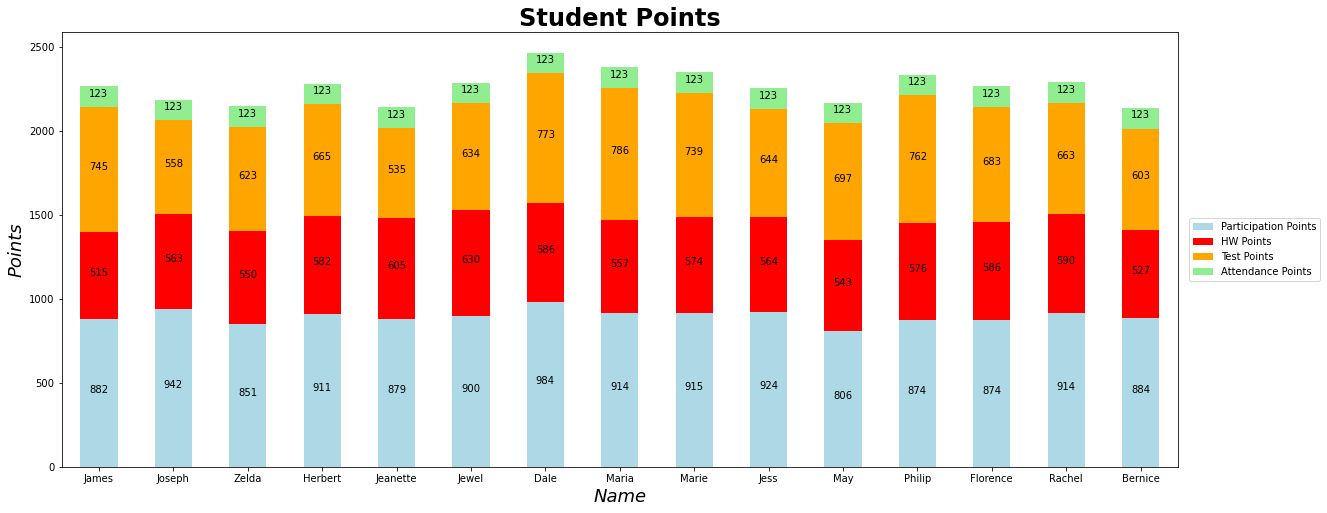

In [71]:
# Set the title
oTitle = f"({tiMonth}-{tiYear}) Class {tiClassID} - Points"
# Prepare DataFrame
dfPointsBLAH = dfPoints[['PARTICIPATION_POINTS', 'HW_POINTS', 'TEST_POINTS', 'ATTENDANCE_POINTS', 'STUDENT_NAME_ENGLISH']]
# Define color deficient-friendly colors
my_colors = list(islice(cycle(['lightblue', 'red', 'orange', 'lightgreen']), None, len(dfPointsBLAH)))
# Plot it
ax = dfPointsBLAH.plot.bar(x = 'STUDENT_NAME_ENGLISH', figsize=(20,8), stacked = True, color = my_colors, rot = 0)
# Set up the legend
ax.legend(['Participation Points', 'HW Points', 'Test Points', 'Attendance Points'], bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0)
# Format the graph
ax.set_title("Student Points", size = 24, ha = 'center', fontweight = 'bold')
ax.set_xlabel("Name", size = 18, style="italic")
ax.set_ylabel("Points", size = 18, style="italic")
# Add Labels
fShowValuesOnBarsCenter(ax, 0, 2)
# Save the figure as png
ax.figure.savefig(f"Images\{oTitle}.png", bbox_inches = 'tight')
# Append the plot to a list
lParticipationPlots.append(f"{oTitle}.png")
# Close the plot to stop it dislaying
#plt.close()